# Introduction

This notebook presents **YOLOv2** applied to the [Blood Cell Images](https://www.kaggle.com/paultimothymooney/blood-cells) dataset.

**Resources**

* [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset) - alternative dataset source with links to original authors

# Imports

In [146]:
import os
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image
import PIL.ImageDraw
import xml.etree.ElementTree as ET


Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Configuration

In [3]:
dataset_location = '/home/marcin/Datasets/blood-cells/dataset-master/'

In [4]:
anchors = ((0.57273, 0.677385),  # anchor-box nb 1, width & height, unit: cell_size
           (1.87446, 2.06253),   # anchor-box nb 2,
           (3.33843, 5.47434),   # ...
           (7.88282, 3.52778),
           (9.77052, 9.16828))

In [5]:
images_location = os.path.join(dataset_location, 'JPEGImages')
annotations_location = os.path.join(dataset_location, 'Annotations')

In [6]:
filename_list_xml = sorted(os.listdir(annotations_location))
display(filename_list_xml[:3])

['BloodImage_00000.xml', 'BloodImage_00001.xml', 'BloodImage_00002.xml']

In [7]:
class ImageWrapper:
    def __init__(self, filepath, width, height, depth):
        self.filepath = filepath
        self.width = width
        self.height = height
        self.depth = depth
        self.objects = []
    def __str__(self):
        return f'{self.filepath}\nw:{self.width} h:{self.height} d:{self.depth}'

In [8]:
class BBoxWrapper:
    def __init__(self, name, xmin ,ymin, xmax, ymax):
        self.name = name
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    def __str__(self):
        return f'{self.name} {self.xmin} {self.ymin} {self.xmax} {self.ymax}'

In [9]:
image_wrapper_list = []

for filename_xml in filename_list_xml:       # 'BloodImage_00000.xml'
    filepath_xml = os.path.join(             # '/../../BloodImage_00000.xml'
        annotations_location, filename_xml)  
    tree = ET.parse(filepath_xml)            # xml.etree.ElementTree.ElementTree
    
    filename = tree.find('./filename').text  # 'BloodImage_00000'
    w = tree.find('./size/width').text       # '640'
    h = tree.find('./size/height').text      # '480'
    d = tree.find('./size/depth').text       # '3'
    
    filepath_jpg = os.path.join(             # '/../../BloodImage_00000.jpg'
        images_location, filename+'.jpg')
    
    assert os.path.isfile(filepath_jpg)
    
    iw = ImageWrapper(filepath=filepath_jpg, width=int(w),
                      height=int(h), depth=int(d))
    
    object_elemnts = tree.findall('./object')  # [xml.etree.ElementTree.ElementTree, ...]
    for obj_el in object_elemnts:
    
        name = obj_el.find('./name').text         # 'RBC'
        xmin = obj_el.find('./bndbox/xmin').text  # '233'
        ymin = obj_el.find('./bndbox/ymin').text  # '368'
        xmax = obj_el.find('./bndbox/xmax').text  # '338'
        ymax = obj_el.find('./bndbox/ymax').text  # '452'
        
        bbw = BBoxWrapper(name=name, xmin=int(xmin), ymin=int(ymin),
                           xmax=int(xmax), ymax=int(ymax))
        
        iw.objects.append(bbw)
        
    image_wrapper_list.append(iw)

In [10]:
for img_wrapper in image_wrapper_list:
    print(img_wrapper)
    for bbox_wrapper in img_wrapper.objects:
        print('  ', bbox_wrapper)
    break

/home/marcin/Datasets/blood-cells/dataset-master/JPEGImages/BloodImage_00000.jpg
w:640 h:480 d:3
   RBC 216 359 316 464
   RBC 77 326 177 431
   RBC 540 353 640 458
   RBC 405 350 513 457
   RBC 160 72 245 177
   RBC 5 335 90 440
   RBC 540 39 640 149
   RBC 383 1 504 113
   RBC 9 82 108 168
   RBC 68 212 165 346
   RBC 171 181 264 282


**Data Loader**

In [133]:

'''THIS IS NOT FULLY PORTED YET, JUST COPIED FROM CatKeypoints'''

class BloodSequence(tf.keras.utils.Sequence):
    def __init__(self, image_wrapper_list, target_size, number_cells,
                 anchors, class_names, batch_size,
                 preprocess_images_function=None,
                 #preprocess_keypts_function=None,
                 shuffle=False):
        assert isinstance(image_wrapper_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert isinstance(number_cells, int) and number_cells > 0
        assert isinstance(anchors, (tuple, list))
        assert isinstance(anchors[0], (tuple, list)) and len(anchors[0]) == 2  # 2 = w,h
        assert isinstance(class_names, (tuple, list))
        assert isinstance(class_names[0], str)
        assert isinstance(batch_size, int) and batch_size > 0
        assert preprocess_images_function is None or callable(preprocess_images_function)
        #assert preprocess_keypts_function is None or callable(preprocess_keypts_function)
        assert isinstance(shuffle, bool)
        
        if target_size / number_cells != 32:
            raise ValueError(
                'target_size and number_cells must be such that cell width is 32')
        self.cell_width = 32
        self.cell_height = 32
    
        self.image_wrapper_list = np.array(image_wrapper_list)  # for advanced indexing
        self.target_size = target_size        # int, e.g. 416
        self.number_cells = number_cells      # int, e.g. 13
        self.anchors = anchors                # [[anchor_1_w, anchor_1_h], ...]
        self.class_names = class_names        # ['cat', 'dot', ...]
        self.batch_size = batch_size
        self.preprocess_images_function = preprocess_images_function
        #self.preprocess_keypts_function = preprocess_keypts_function
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.ceil(len(self.files_list) / self.batch_size))
    
    
    def __getitem__(self, idx):
        iii = 0
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_iw = self.image_wrapper_list[batch_i]    # [ImageWrapper, ...]
        
                
        images_shape = (
            len(batch_iw),      # batch size
            self.target_size,   # width, 416
            self.target_size,   # height, 416
            3,                  # nb channels, RGB
        )
        
        targets_shape = (
            len(batch_iw),                  # batch size
            self.number_cells,              # nb cells x, 13
            self.number_cells,              # nb cells y, 13
            len(self.anchors),              # nb anchors
            4 + 1 + len(self.class_names))  # x,y,w,h, conf, clases
        
        images_arr = np.zeros(shape=images_shape, dtype=np.uint8)
        targets_arr = np.zeros(shape=targets_shape, dtype=float)
        
        
        for i, img_wrapper in enumerate(batch_iw):

            #
            #   Load Image
            #
            image = PIL.Image.open(img_wrapper.filepath)
            image_w, image_h = image.size
            image_new = image.resize((self.target_size, self.target_size),
                                     resample=PIL.Image.LANCZOS)
            images_arr[i] = np.array(image_new)
            
            #
            #   Load Objects
            #
            for obj_wrapper in img_wrapper.objects:
                
                if obj_wrapper.name not in self.class_names:
                    continue
                
                xmin, ymin = obj_wrapper.xmin, obj_wrapper.ymin  # unit: input img pixels
                xmax, ymax = obj_wrapper.xmax, obj_wrapper.ymax
                
                center_x_px = (xmin + xmax) / 2    # bounding box center
                center_y_px = (ymin + ymax) / 2    # unit: input img pixels, [0..image_h]
                size_w_px = (xmax-xmin)            # bounding box width & height
                size_h_px = (ymax-ymin)            # unit: input img pixels, [0..image_h]
                
                center_x_01 = (center_x_px / image_w)  # range: [0..1]
                center_y_01 = (center_y_px / image_h)
                size_w_01 = size_w_px / image_w
                size_h_01 = size_h_px / image_h
                
                center_x_cells = center_x_01 * self.number_cells  # range: [0..nb_cells]
                center_y_cells = center_y_01 * self.number_cells
                size_w_cells = size_w_01 * self.number_cells
                size_h_cells = size_h_01 * self.number_cells
                
                grid_x_loc = int(np.floor(center_x_cells))
                grid_y_loc = int(np.floor(center_y_cells))
                
                print('---')
                print('center_x/y', center_x_cells, center_y_cells)
                print('center w/h', size_w_cells, size_h_cells)
                print('grid_x/y', grid_x_loc, grid_y_loc)

                # find highest IoU anchor
                best_anchor_loc, best_iou = 0, 0
                for anchor_loc, anchor_wh in enumerate(self.anchors):
                    (anchor_w_cells, anchor_h_cells) = anchor_wh
                    
                    intersect_w = min(size_w_cells, anchor_w_cells)
                    intersect_h = min(size_h_cells, anchor_h_cells)
                    intersect_area = intersect_w * intersect_h
                    union_w = max(size_w_cells, anchor_w_cells)
                    union_h = max(size_h_cells, anchor_h_cells)
                    union_area = union_w * union_h
                    
                    IoU = intersect_area / union_area
                    if IoU > best_iou:
                        best_iou = IoU
                        best_anchor_loc = anchor_loc
                        
                    #print('a_w/h', anchor_w_cells, anchor_h_cells)
                    print('  a_loc/iou', anchor_loc, IoU)
                    
                print('best anchor/iou', iii, best_anchor_loc) #, best_iou)
                iii += 1
                
                class_idx = self.class_names.index(obj_wrapper.name)
                target = np.zeros(shape=(4 + 1 + len(self.class_names)), dtype=float)
                target[0] = center_x_cells
                target[1] = center_y_cells
                target[2] = size_w_cells
                target[3] = size_h_cells
                target[4] = 1.0
                target[5 + class_idx] = 1.0
                
                targets_arr[i, grid_x_loc, grid_y_loc, best_anchor_loc] = target
                
                #print('hoho', center_x_cells, center_y_cells, size_w_cells, size_h_cells)
                
                
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        
        return images_arr, targets_arr
        
        images_list, keypoints_list = [], []
        for file_path in batch_fl:
            _, _, image_new, keypoints_new = load_image_keypoints(
                file_path, file_path+'.cat', target_size=self.target_size)
            image_arr = np.array(image_new)
            images_list.append(image_arr)
            keypoints_list.append(keypoints_new)
        
        images_arr = np.array(images_list)
        keypoints_arr = np.array(keypoints_list)
        
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        if self.preprocess_keypts_function is not None:
            keypoints_arr = self.preprocess_keypts_function(keypoints_arr)
        
        return images_arr, keypoints_arr

    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_wrapper_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [134]:
int(3.8)

3

In [135]:
def preproc_images(images_arr):
    assert isinstance(images_arr, np.ndarray)
    assert images_arr.dtype == np.uint8
    return images_arr / 255

In [136]:
batches = BloodSequence(image_wrapper_list, target_size=416, number_cells=13, 
                        anchors=anchors, class_names=['RBC'], batch_size=16, shuffle=False,
                       preprocess_images_function=preproc_images)

In [ ]:
x_batch, y_batch = batches[0]

In [140]:
x_batch.shape

(16, 416, 416, 3)

In [141]:
x_batch[0].min()

0.4235294117647059

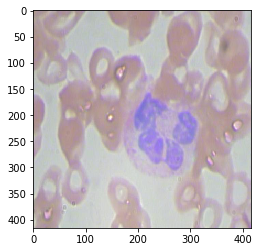

In [142]:
plt.imshow(x_batch[0])

In [143]:
y_batch.shape

(16, 13, 13, 5, 6)

In [ ]:
y_batch[0]

In [144]:
img_w = 416
img_h = 416
grid_w = 13
grid_h = 13
cell_w = img_w / grid_w  # 32
cell_h = img_h / grid_h  # 32

boundig_boxes = []

y_data = y_batch[0]
for ghi in range(y_data.shape[0]):
    for gwi in range(y_data.shape[1]):
        for ai in range(y_data.shape[2]):
            anchor = y_data[ghi][gwi][ai]
        
        
            if anchor.max() != 0:
                


                bbox_center_x = cell_w * anchor[0]
                bbox_center_y = cell_h * anchor[1]
                bbox_width = cell_w * anchor[2]
                bbox_height = cell_h * anchor[3]
                
                x1 = bbox_center_x-bbox_width/2
                y1 = bbox_center_y-bbox_height/2
                x2 = bbox_center_x+bbox_width/2
                y2 = bbox_center_y+bbox_height/2
                
                boundig_boxes.append((x1, y1, x2, y2))

In [145]:
image = (x_batch[0] * 255).astype(np.uint8).copy()

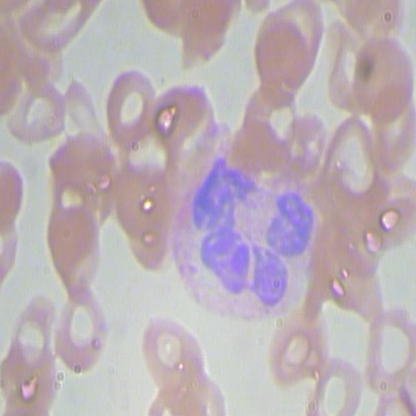

In [147]:
pil_img = PIL.Image.fromarray(image)
pil_img

In [148]:
draw = PIL.ImageDraw.Draw(pil_img)

In [149]:
for bbox in boundig_boxes:
    #draw.ellipse(bbox,
    #             fill=(255,0,0), outline=(255,0,0))
    draw.rectangle(bbox,
                   outline=(255,0,0))

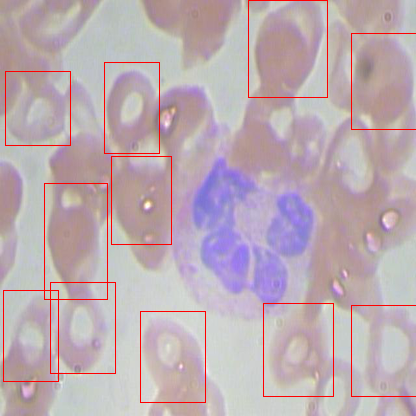

In [150]:
pil_img